In [ ]:
!pip install albumentations
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1Xk61ZGL6alVebv-oyiqecDzRU0PSliOL
!gdown --id 1V7y8swH6EQVAb4ny-7kWrb786EvafxNz

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Xk61ZGL6alVebv-oyiqecDzRU0PSliOL 

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive

In [ ]:
!unzip content/archive.zip
!unzip content/data.zip

Archive:  content/archive.zip
  inflating: images/09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg  
  inflating: images/1eecab90-1a92-43a7-b952-0204384e1fae.jpg  
  inflating: images/2C29D473-CCB4-458C-926B-99D0042161E6.jpg  
  inflating: images/2c376c66-9823-4874-869e-1e7f5c54ec7b.jpg  
  inflating: images/34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg  
  inflating: images/3493127D-7B19-4E50-94AE-2401BD2A91C8.jpg  
  inflating: images/41d83dbb-7c39-4d91-979e-eec5ff71b265.jpg  
  inflating: images/4252e46c-e40f-4543-91ab-031917d46c5c.jpg  
  inflating: images/4c46b91a-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c472e18-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c478f3e-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c484f8c-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c48acb6-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c490eae-e402-11e8-97db-0242ac1c0002.jpg  
  inflating: images/4c49b

Image segmentation is the process of classifying each pixel. The are different approaches:

* semantic segmentation - we dont separate different instances of the same class (multiple dogs on the image)
* instance segmentation - for each separate instance (for each dog, human, etc) we have separate prediction for each of them

Image segmentation is used for:
* photo editors - remove/blur background
* image search engines - identify different objects on the image
* autonomous vehicle - to understand the environment
* medical purposes

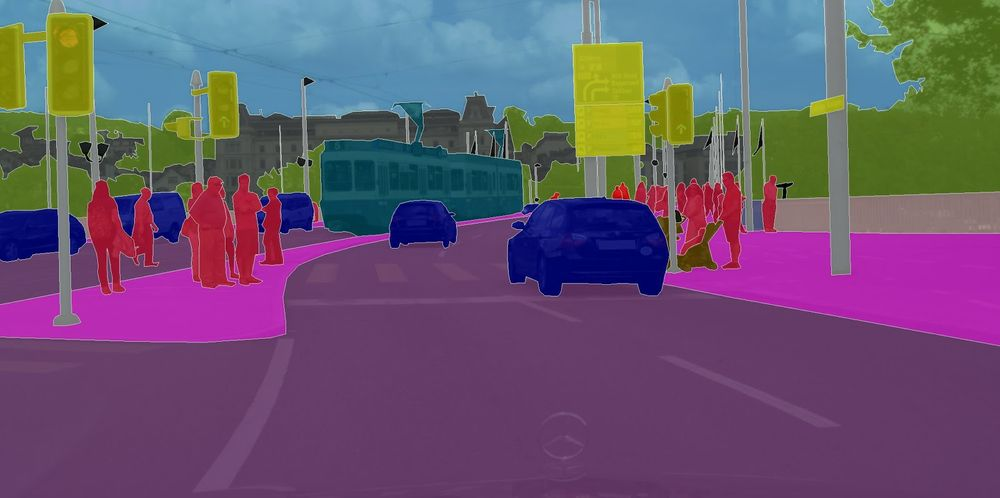

https://medium.com/intro-to-artificial-intelligence/semantic-segmentation-udaitys-self-driving-car-engineer-nanodegree-c01eb6eaf9d

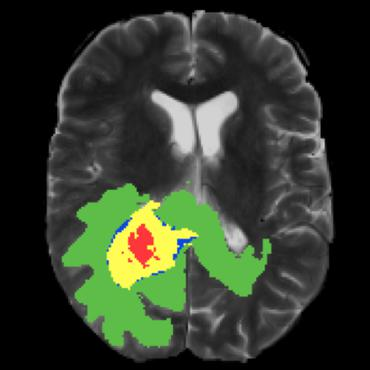


https://github.com/naldeborgh7575/brain_segmentation

# Semantic segmentation

In [ ]:
import torch
import albumentations as A
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

## Evaluation
At first, we need to understand how to measure the quality of the model.



## Intersection over Union (Jaccard Index)

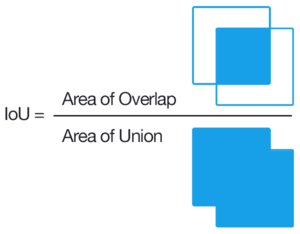


In [ ]:
mask_real = torch.zeros((1, 3, 16, 16))
mask_real[:, 1:, 8:, 8:] = 1
mask_real[:, 0, 13:, 8:] = 1

mask_pred = torch.zeros((1, 3, 16, 16))
mask_pred[:, 1:, 5:12, 5:12] = 1
mask_pred[:, 0, 9:14, 5:12] = 1

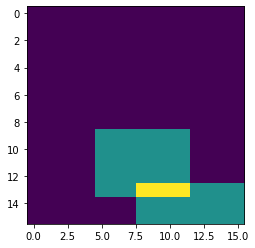

In [ ]:
# intersection
plt.imshow(mask_real[0][0] + mask_pred[0][0])

IoU metric can be calculated in a simple way

In [ ]:
def iou(pred, real):
    intersection = torch.sum(pred * real, [2, 3])

    union = torch.sum(pred, [2, 3]) + torch.sum(real, [2, 3]) - intersection

    res = torch.mean((intersection + 1e-6) / (union + 1e-6), 0)

    return res

In [ ]:
iou(mask_pred, mask_real)

tensor([0.0727, 0.1649, 0.1649])

## Dice coefficient

![](https://drive.google.com/uc?export=view&id=1OSwuwDQrYbF_I5IGGBOtrHIMblL9T2za)

In [ ]:
def dice(pred, real):
    intersection = 2 * torch.sum(pred * real, [2, 3])

    union = torch.sum(pred, [2, 3]) + torch.sum(real, [2, 3])

    res = torch.mean((intersection + 1e-6) / (union + 1e-6), 0)

    return res

In [ ]:
dice(mask_pred, mask_real)

tensor([0.1356, 0.2832, 0.2832])

## Primitive approach
For example we want binary segmentation (detect single-class object on an image)

We use simple dataset of nails segmentation (thanks Victor Papenko, https://www.kaggle.com/vpapenko/nails-segmentation)

### Dataset
First of all define our dataloader class

In [ ]:
import torch
import albumentations as A
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

In [ ]:
images_name = os.listdir('/content/images')

# A.Compose is like torch.nn.Sequential
transformation = A.Compose([
    A.PadIfNeeded(64, 64),
    A.Resize(64, 64),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

In [ ]:
class Dataset():
    def __init__(self, image_names, image_dir, labels_dir, transform=None, train=True):
        self.image_names = image_names
        self.image_dir = image_dir
        self.labels_dir = labels_dir
        self.transform = transform

        self.train = train

    def __getitem__(self, index):
        # this is default function, which have index parameter in range(0, __len__)
        img_name = self.image_names[index]  # select name of the file to get
        path = os.path.join(self.image_dir, img_name)  # create path to this file
        path_mask = os.path.join(self.labels_dir, img_name)  # create path to this file

        # read image using opencv lib (cv2)
        img = cv2.imread(path)
        mask = cv2.imread(path_mask)[:, :, :2]  # we read mask as jpg with 3 channels, we need only 1 of them
        # also, mask have jpg compression errors, we need to filter them
        mask[np.where(mask < 5)] = 0
        mask[np.where(mask > 150)] = 1

        mask[:, :, 1] = mask[:, :, 0]
        mask[:, :, 0] = 1 - mask[:, :, 0]

        if self.transform is not None:
            img = self.transform(
                image= (img),
                mask= (mask)
            )

        result = {
            'image_name': img_name,
            'image': torch.tensor(img['image']).transpose(-1, 0).transpose(-1, -2).float(),  # we transpose data so the first dimension is channel
            'mask': torch.tensor(img['mask']).transpose(-1, 0).transpose(-1, -2).float() if self.train else None
        }

        return result

    def __len__(self, ):
        return len(self.image_names)

In [ ]:
images_name = os.listdir('/content/images')

# A.Compose is like torch.nn.Sequential
transformation = A.Compose([
    A.PadIfNeeded(64, 64),
    A.Resize(64, 64),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

In [ ]:
dataset = Dataset(images_name, '/content/images', '/content/labels', transformation)

### Linear model

We can approach this task as a binary classification of each pixel. So, define the output of the network as a small convolutional NN with one long vector output.

![](https://drive.google.com/uc?export=view&id=1-FI-TWg32CYA1t6jcKW9QKthMjWr0DzN)

In [ ]:
class Dummy(torch.nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()

        encoder = torchvision.models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
            encoder.maxpool,
            encoder.layer1,
            encoder.layer2,
            encoder.avgpool
        )

        self.linear_predictor = torch.nn.Linear(512, 64 * 64 * 2)
        self.activation = torch.nn.Sigmoid()

    def forward(self, image):
        x = self.model(image).view(image.shape[0], 512)
        x = self.linear_predictor(x)
        # x = self.activation(x)

        return x

In [ ]:
model = Dummy().cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model.linear_predictor

Linear(in_features=512, out_features=8192, bias=True)

Also, if we work with pretrained network, we don't want to change its' weights a lot.

We use different optimization for pretrained resnet50 and our classification layer with different learning rates

In [ ]:
dataloader = DataLoader(dataset, 32, True)

opt1 = torch.optim.AdamW(model.model.parameters(), lr=1e-6)
opt2 = torch.optim.AdamW(model.linear_predictor.parameters(), lr=1e-3)
loss_f = torch.nn.BCEWithLogitsLoss()

epochs = 10

In [ ]:
for epoch in range(epochs):
    for i, sample in enumerate(dataloader):
        opt1.zero_grad()
        opt2.zero_grad()
        predict = model(sample['image'].cuda())

        loss = loss_f(predict, sample['mask'].cuda().flatten(1, ))
        loss.backward()

        opt1.step()
        opt2.step()

        if i % 3 == 0:
            print('Epoch: {}\tLoss: {}'.format(epoch, round(loss.item(), 3)))

Epoch: 0	Loss: 0.694
Epoch: 1	Loss: 0.643
Epoch: 2	Loss: 0.597
Epoch: 3	Loss: 0.552
Epoch: 4	Loss: 0.515
Epoch: 5	Loss: 0.471
Epoch: 6	Loss: 0.439
Epoch: 7	Loss: 0.411
Epoch: 8	Loss: 0.391
Epoch: 9	Loss: 0.356


Result is not really good

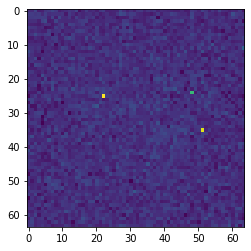

In [ ]:
plt.imshow(predict.reshape(predict.shape[0], 2, 64, 64)[5][1].cpu().detach().numpy())

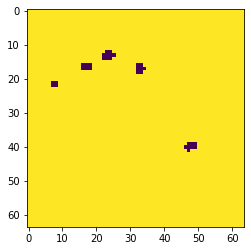

In [ ]:
plt.imshow(sample['mask'][5][0].cpu().detach().numpy())

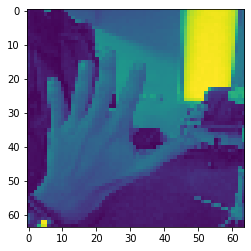

In [ ]:
plt.imshow(sample['image'][5][0].cpu().detach().numpy())

## Pyramid Pooling approach

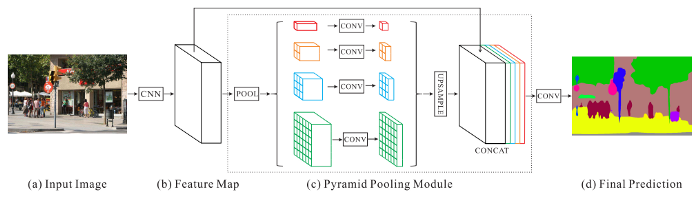



https://arxiv.org/pdf/1612.01105.pdf

![](https://drive.google.com/uc?export=view&id=1DxGfncl_npu9LMswreh8BspfHt6q4jQc)

We use 3 different convolutions. Each of them have different receptive field and detect different features (small, medium, large)

Results of these layers are concatenated along feature dimensions and processed by 1x1 convolution

This is Fully Convolutional Neural Network - only convolution operations, pooling and batch-norm

In [ ]:
class Upsam(torch.nn.Module):
    def __init__(self):
        super(Upsam, self).__init__()

        encoder = torchvision.models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
            encoder.maxpool,
            encoder.layer1,
            encoder.layer2
        )

        self.upconv1 = torch.nn.Conv2d(512, 32, (1, 1), 1)
        self.upconv2 = torch.nn.Conv2d(512, 32, (3, 3), 1)
        self.upconv3 = torch.nn.Conv2d(512, 32, (5, 5), 1)

        self.conv1x1 = torch.nn.Conv2d(96, 2, (1, 1))

        self.linear_predictor = torch.nn.Linear(256, 64 * 64)
        self.activation = torch.nn.Softmax2d()
        self.relu = torch.nn.ReLU()

    def forward(self, image):
        x = self.model(image)
        _x = x
        # x = self.heater(x)
        x1 = self.relu(self.upconv1(x))
        x2 = self.relu(self.upconv2(x))
        x3 = self.relu(self.upconv3(x))

        x1 = torch.nn.functional.interpolate(x1, (image.shape[2], image.shape[3]))
        x2 = torch.nn.functional.interpolate(x2, (image.shape[2], image.shape[3]))
        x3 = torch.nn.functional.interpolate(x3, (image.shape[2], image.shape[3]))
        # _x = torch.nn.functional.interpolate(_x, (image.shape[2], image.shape[3]))

        x = torch.cat([x1, x2, x3], 1)
        x = self.conv1x1(x)
        # x = self.activation(x)

        return x

In [ ]:
images_name = os.listdir('/content/images')

# A.Compose is like torch.nn.Sequential
transformation = A.Compose([
    A.PadIfNeeded(128, 128),
    A.Resize(128, 128),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

dataset = Dataset(images_name, '/content/images', '/content/labels', transformation)

In [ ]:
model = Upsam().cuda()

In [ ]:
dataloader = DataLoader(dataset, 32, True)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4)
loss_f = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.1, 2.0]).cuda().reshape(1, 2, 1, 1))

epochs = 50

In [ ]:
for epoch in range(epochs):
    for i, sample in enumerate(dataloader):
        opt.zero_grad()
        predict = model(sample['image'].cuda().detach())

        loss = loss_f(predict.cuda(), sample['mask'].cuda().detach())
        loss.backward()

        opt.step()

        if i % 3 == 0:
            print('Epoch: {}\tLoss: {}'.format(epoch, round(loss.item(), 3)))

Epoch: 0	Loss: 0.387
Epoch: 1	Loss: 0.221
Epoch: 2	Loss: 0.167
Epoch: 3	Loss: 0.188
Epoch: 4	Loss: 0.154
Epoch: 5	Loss: 0.141
Epoch: 6	Loss: 0.158
Epoch: 7	Loss: 0.134
Epoch: 8	Loss: 0.108
Epoch: 9	Loss: 0.135
Epoch: 10	Loss: 0.125
Epoch: 11	Loss: 0.119
Epoch: 12	Loss: 0.091
Epoch: 13	Loss: 0.104
Epoch: 14	Loss: 0.096
Epoch: 15	Loss: 0.098
Epoch: 16	Loss: 0.087
Epoch: 17	Loss: 0.095
Epoch: 18	Loss: 0.082
Epoch: 19	Loss: 0.089
Epoch: 20	Loss: 0.087
Epoch: 21	Loss: 0.08
Epoch: 22	Loss: 0.074
Epoch: 23	Loss: 0.071
Epoch: 24	Loss: 0.073
Epoch: 25	Loss: 0.066
Epoch: 26	Loss: 0.064
Epoch: 27	Loss: 0.06
Epoch: 28	Loss: 0.047
Epoch: 29	Loss: 0.047
Epoch: 30	Loss: 0.043
Epoch: 31	Loss: 0.041
Epoch: 32	Loss: 0.035
Epoch: 33	Loss: 0.044
Epoch: 34	Loss: 0.036
Epoch: 35	Loss: 0.032
Epoch: 36	Loss: 0.03
Epoch: 37	Loss: 0.032
Epoch: 38	Loss: 0.044
Epoch: 39	Loss: 0.042
Epoch: 40	Loss: 0.021
Epoch: 41	Loss: 0.023
Epoch: 42	Loss: 0.017
Epoch: 43	Loss: 0.02
Epoch: 44	Loss: -0.02
Epoch: 45	Loss: -0.051
E

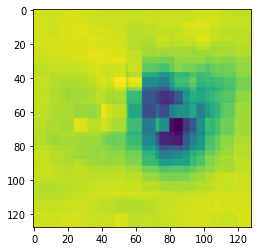

In [ ]:
plt.imshow(predict.reshape(predict.shape[0], 2, 128, 128)[2][1].cpu().detach().numpy())

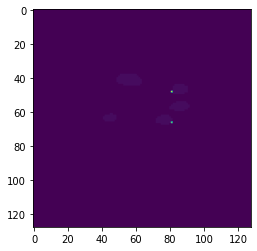

In [ ]:
plt.imshow(sample['mask'][2][1].detach().numpy())

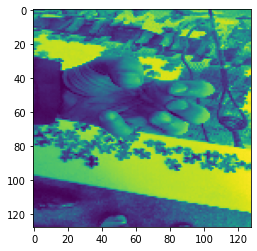

In [ ]:
plt.imshow(sample['image'][2][0].detach().numpy())

## Simple skip-connection

In previous variants, we predicted probabilities for pixels using only the output value of the neural network, which extracts the features (resnet layers in our case). These features can be considered as a summary of the content of the original image, the details are lost in them - the exact position of the borders, colors.

To make the segmentation more accurate it was proposed to use skip-connection from earlier layers of the neural network, where the detailed information has not yet been lost.

![](https://drive.google.com/uc?export=view&id=1YGSWsX6aGf12nDrqxRMWEV0AXUHtjOop)

In [ ]:
class SSkip(torch.nn.Module):
    def __init__(self):
        super(SSkip, self).__init__()

        encoder = torchvision.models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
            encoder.maxpool,
            encoder.layer1,
        )
        self.encoder_layer2 = encoder.layer2

        self.upconv1 = torch.nn.Conv2d(512, 32, (1, 1), 1)
        self.upconv2 = torch.nn.Conv2d(512, 32, (3, 3), 1)
        self.upconv3 = torch.nn.Conv2d(512, 32, (5, 5), 1)

        self.conv1x1 = torch.nn.Conv2d(96 + 256, 2, (1, 1))

        self.linear_predictor = torch.nn.Linear(256, 64 * 64)
        self.activation = torch.nn.Softmax2d()
        self.relu = torch.nn.ReLU()

    def forward(self, image):
        x = self.model(image)
        x_to_skip = x
        x = self.encoder_layer2(x)
        _x = x
        # x = self.heater(x)
        x1 = self.relu(self.upconv1(x))
        x2 = self.relu(self.upconv2(x))
        x3 = self.relu(self.upconv3(x))

        x1 = torch.nn.functional.interpolate(x1, (image.shape[2], image.shape[3]))
        x2 = torch.nn.functional.interpolate(x2, (image.shape[2], image.shape[3]))
        x3 = torch.nn.functional.interpolate(x3, (image.shape[2], image.shape[3]))
        x_to_skip = torch.nn.functional.interpolate(x_to_skip, (image.shape[2], image.shape[3]))

        x = torch.cat([x1, x2, x3, x_to_skip], 1)
        x = self.conv1x1(x)
        # x_to_skip = self.activation(x)

        return x

In [ ]:
images_name = os.listdir('/content/images')

# A.Compose is like torch.nn.Sequential
transformation = A.Compose([
    A.PadIfNeeded(128, 128),
    A.Resize(128, 128),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

dataset = Dataset(images_name, '/content/images', '/content/labels', transformation)

In [ ]:
model = SSkip().cuda()

In [ ]:
dataloader = DataLoader(dataset, 32, True)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4)
loss_f = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.1, 2.0]).cuda().reshape(1, 2, 1, 1))

epochs = 50

In [ ]:
for epoch in range(epochs):
    for i, sample in enumerate(dataloader):
        opt.zero_grad()
        predict = model(sample['image'].cuda().detach())

        loss = loss_f(predict.cuda(), sample['mask'].cuda().detach())
        loss.backward()

        opt.step()

        if i % 3 == 0:
            print('Epoch: {}\tLoss: {}'.format(epoch, round(loss.item(), 3)))

Epoch: 0	Loss: 0.416
Epoch: 1	Loss: 0.29
Epoch: 2	Loss: 0.208
Epoch: 3	Loss: 0.191
Epoch: 4	Loss: 0.18
Epoch: 5	Loss: 0.154
Epoch: 6	Loss: 0.125
Epoch: 7	Loss: 0.118
Epoch: 8	Loss: 0.117
Epoch: 9	Loss: 0.114
Epoch: 10	Loss: 0.114
Epoch: 11	Loss: 0.102
Epoch: 12	Loss: 0.077
Epoch: 13	Loss: 0.091
Epoch: 14	Loss: 0.1
Epoch: 15	Loss: 0.098
Epoch: 16	Loss: 0.079
Epoch: 17	Loss: 0.079
Epoch: 18	Loss: 0.07
Epoch: 19	Loss: 0.075
Epoch: 20	Loss: 0.07
Epoch: 21	Loss: 0.072
Epoch: 22	Loss: 0.075
Epoch: 23	Loss: 0.056
Epoch: 24	Loss: 0.054
Epoch: 25	Loss: 0.059
Epoch: 26	Loss: 0.052
Epoch: 27	Loss: 0.051
Epoch: 28	Loss: 0.052
Epoch: 29	Loss: 0.049
Epoch: 30	Loss: 0.048
Epoch: 31	Loss: 0.039
Epoch: 32	Loss: 0.049
Epoch: 33	Loss: 0.043
Epoch: 34	Loss: 0.041
Epoch: 35	Loss: 0.026
Epoch: 36	Loss: 0.027
Epoch: 37	Loss: 0.027
Epoch: 38	Loss: 0.037
Epoch: 39	Loss: 0.025
Epoch: 40	Loss: 0.015
Epoch: 41	Loss: 0.025
Epoch: 42	Loss: 0.037
Epoch: 43	Loss: 0.015
Epoch: 44	Loss: 0.032
Epoch: 45	Loss: 0.007
Epoc

In [ ]:
predict[torch.where(predict > 0.5)] = 1.0
predict[torch.where(predict <= 0.5)] = 0.0

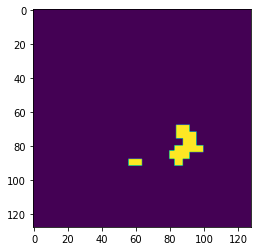

In [ ]:
plt.imshow(predict.reshape(predict.shape[0], 2, 128, 128)[2][1].cpu().detach().numpy())

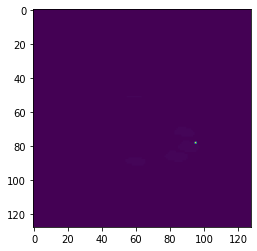

In [ ]:
plt.imshow(sample['mask'][2][1].detach().numpy())

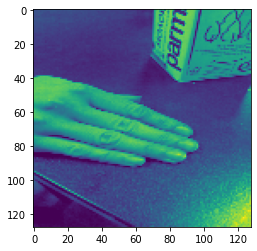

In [ ]:
plt.imshow(sample['image'][2][0].detach().numpy())

## U-Net approach

The now more advanced and widespread approach continues the idea of skip-connections.

We extract features from images on different layer and then pass them to the deconvolutional part of the network (decoder, expansion-net, transpose)

![](https://drive.google.com/uc?export=view&id=1ebODfziK37_zEIpQv4To6RJUPYJQD8-6)

In [ ]:
class SSkip(torch.nn.Module):
    def __init__(self):
        super(SSkip, self).__init__()

        encoder = torchvision.models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
        )
        self.max_pool = encoder.maxpool
        self.encoder_layer1 = encoder.layer1
        self.encoder_layer2 = encoder.layer2
        self.encoder_layer3 = encoder.layer3

        self.upconv1 = torch.nn.ConvTranspose2d(1024, 512, (2, 2), 2)
        self.upconv1_1 = torch.nn.Conv2d(1024, 512, (3, 3), padding=(1, 1))

        self.upconv2 = torch.nn.ConvTranspose2d(512, 256, (2, 2), 2)
        self.upconv2_1 = torch.nn.Conv2d(512, 256, (3, 3), padding=(1, 1))

        self.upconv3 = torch.nn.ConvTranspose2d(256, 64, (2, 2), 2)
        self.upconv3_1 = torch.nn.Conv2d(128, 2, (1, 1))

        self.relu = torch.nn.ReLU()

    def forward(self, image):
        features_to_pass = []

        x = self.model(image)
        features_to_pass.append(x)

        x = self.max_pool(x)
        x = self.encoder_layer1(x)
        features_to_pass.append(x)

        x = self.encoder_layer2(x)
        features_to_pass.append(x)

        x = self.encoder_layer3(x)

        # first upsample convolution
        x = self.upconv1(x)
        # concatenate with corresponding feature map
        x = torch.cat([x, features_to_pass.pop()], axis=1)  # we use pop here to avoid hardcoded indexing, axis=1 - feature dimensions
        x = self.upconv1_1(x)

        x = self.upconv2(x)
        x = torch.cat([x, features_to_pass.pop()], axis=1)
        x = self.upconv2_1(x)

        x = self.upconv3(x)
        x = torch.cat([x, features_to_pass.pop()], axis=1)
        x = self.upconv3_1(x)

        # apply bilinear upsampling without trainable parameters, just to match input image size
        x = torch.nn.functional.interpolate(x, (image.shape[2], image.shape[3]))
        return x

In [ ]:
images_name = os.listdir('/content/images')

# A.Compose is like torch.nn.Sequential
transformation = A.Compose([
    A.PadIfNeeded(224, 224),
    A.Resize(224, 224),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

dataset = Dataset(images_name, '/content/images', '/content/labels', transformation)

In [ ]:
model = SSkip().cuda()

In [ ]:
dataloader = DataLoader(dataset, 32, True)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4)
loss_f = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.1, 2.0]).cuda().reshape(1, 2, 1, 1))

epochs = 5

In [ ]:
for epoch in range(epochs):
    for i, sample in enumerate(dataloader):
        opt.zero_grad()
        predict = model(sample['image'].cuda().detach())

        loss = loss_f(predict.cuda(), sample['mask'].cuda().detach())
        loss.backward()

        opt.step()

        if i % 3 == 0:
            print('Epoch: {}\tLoss: {}'.format(epoch, round(loss.item(), 3)))

Epoch: 0	Loss: 0.427
Epoch: 1	Loss: 0.246
Epoch: 2	Loss: 0.217
Epoch: 3	Loss: 0.169
Epoch: 4	Loss: 0.139


In [ ]:
predict[torch.where(predict > 0.5)] = 1.0
predict[torch.where(predict <= 0.5)] = 0.0

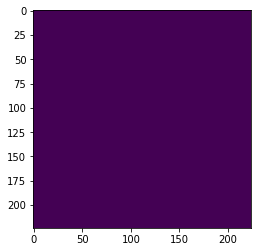

In [ ]:
plt.imshow(predict.reshape(predict.shape[0], 2, 224, 224)[2][1].cpu().detach().numpy())

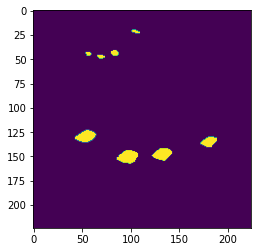

In [ ]:
plt.imshow(sample['mask'][2][1].detach().numpy())

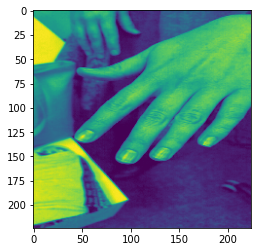

In [ ]:
plt.imshow(sample['image'][2][0].detach().numpy())